# Grid optimisation blueprint for renewable enrgy grids using QAOA

The following is an implemetatin of the Quantum Optimisation Approximation Algorithm (QAOA) for solving the Max Cut Problem for a given graph which represents an energy grid. 

The purpose of using the QAOA to solve the Max Cut problem on such a graph is to attempt to optimsie the layout and connectoins used in a renewable energy grid (represented as a graph) so as to minimsie the energy lost through said connections. This is done in an attempt to use near-quantum approach to further [Goal 7](https://sdgs.un.org/goals/goal7), afforadable and clean energy for all, of the United Nations (UN) [17 goals](https://sdgs.un.org/goals). The primary reason for attempting to optimise the layout of a renewable energy grid is to ensure that a minimal amount of the renewable energy created is lost as a consequence of transportation and storage of this energy.

This implementation works for graphs of any size (any number of nodes) and encodes the grid system as a grpah where nodes represent either a generator (power producer), consumer (consumes certain amount of power) or neutral node (such as a transformer). The edges of these graphs are wieghted. These weights assigned to each edge represent the resistance of the connection between two given nodes.

All the output of this notebook is in the ```out/``` directory for the sake of readibilty (there are lots of graphs).

In [3]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import os

## Explination of the approach

Essentially the idea is to use the Max-Cut algorithm to identify which connections present in the grid (which edges in the graph) should be used to connect different nodes (nodes represent sources which require power or output power). The Max-Cut algorithm partitions the graph (representing the power grid) into two partitions. The between the nodes within a partition (edges between red nodes or between blue nodes in the solution) are low resistance connections which are desirable to use becuase they have a low resistance which results in less power being lost through the connection. The connections (edges) between these two partitions are high resistance connections which are not desriable to use. 

### The relationship between the weight of an edge in the graph and the resistance of the connection

The relatoinship between the weight of an edge in the graph which represents a grid and the resistance of the connection in the grid is as follows,

$$

w_{i,j} = \frac{1}{r_{i,j}}

$$

where the the weight between nodes $i$ and $j$ is represented by $w_{i,j}$ and the resistance of the connection represented by this edge is given by the $r_{i,j}$ term. This relationship results in low resistance connections being favoured over high resistance connections as the max-cut algorithm looks to maximise the the sum of the weights between the two partintions made in the graph.

## Setup

Please note that the edges specified in the ```EDGES``` array are formated as ```(i,j,r)``` for an edge from node `i` to node `j` with resistance `r`.

In [4]:
NUM_LAYERS = 10
STEPS = 250
EDGES = [(0, 1, 1), (0,3,0.1), (0,2,1.0), (1,3,2), (1,2,0.2), (2,3,1)] # edges are formated (i,j,r)

## Build the graph representing the given grid

The diagram shown below shows the graph with the resistances encoded as weights.

{(0, 1): Text(0.032141230733965465, -0.10415996720865794, '1.0'),
 (0, 3): Text(0.130022557982177, 0.8344300384129579, '10.0'),
 (0, 2): Text(-0.41458803526600596, 0.06140769124801482, '1.0'),
 (1, 3): Text(0.4145883953048932, -0.0614046862693145, '0.5'),
 (1, 2): Text(-0.1300200072088472, -0.8344298729104924, '5.0'),
 (3, 2): Text(-0.03214122542106701, 0.10416426480787755, '1.0')}

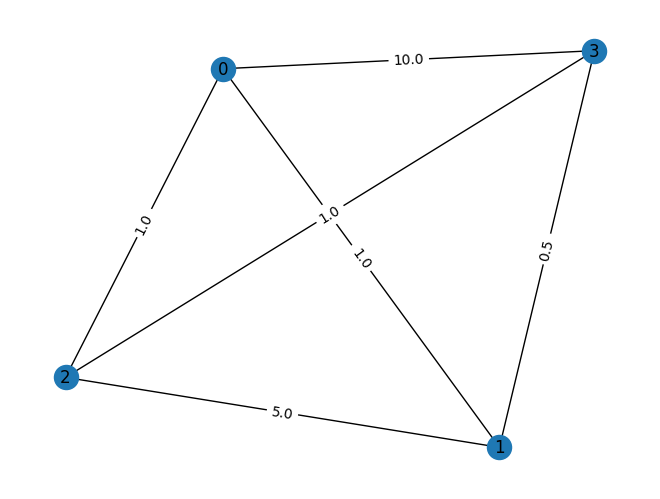

In [5]:
if EDGES == None:
    EDGES = [(0,1)]

if STEPS == None:
    STEPS = 200

if NUM_LAYERS == None:
    NUM_LAYERS = 5

graph = nx.Graph()

# Covnvert the edges with the provided resistance to edges with correct weights
WEIGHT_EDGES = []
for (i,j,r) in EDGES:
    WEIGHT_EDGES.append((i,j,1/r))

# add the edges with the resistances converted to weights to the graph
graph.add_weighted_edges_from(WEIGHT_EDGES)
    

n_wires = len(graph)
pos = nx.spring_layout(graph, seed=7)

nx.draw(graph, nx.spring_layout(graph, seed=7), with_labels=True)
edge_labels = nx.get_edge_attributes(graph, "weight")
nx.draw_networkx_edge_labels(graph,pos, nx.get_edge_attributes(graph, "weight"))

## Defining the cost and mixer Hamiltoians
 
Below the cost Hamiltonian and Mixer Hamiltonian ($ H_M $ / ```mixer_H()```) that are used for the QAOA. It should be noted that the Mixer Hamilitonian is defined as follows, where N is the number of nodes in the grpah:

$$ H_M = X_0 + X_1 + \dots + X_N $$ 

The Cost Hamiltonian ($ H_C $ / ```cost_H()```), is defined slightly differently to the formula usually seen. $ H_C $ is defined as follows, where N again represents the number of nodes in the graph:

$$ H_C = w_{i,j} (Z_i \otimes Z_j), \;  \forall \; (i,j) \in  EDGES $$

Here the $w_{i,j}$ represents the weight of the edge between nodes $i$ and $j$, the weight of the edge is determined using the resistence as mentioned before. The cost Hamilitonian is defined in this way (essentially the negatation of usual formula) as a minimising classical optimizer is used, namely a ```GradientDescentOptimizer```. Therefore the optimizer minimises the negated version given Cost Hamiltonian in order to maximise the given Cost Hamiltonian.

In [6]:
def cost_H():

    coeff = []
    obs = []

    for (i,j,w) in WEIGHT_EDGES:
        coeff.append(w)                                 # co-eff needs to become weight of edge 
        obs.append((qml.PauliZ(i) @ qml.PauliZ(j)))

    return qml.Hamiltonian(coeff, obs)

def mixer_H():

    coeff = []
    obs = []

    for edge in graph:
        coeff.append(1)
        obs.append(qml.PauliX(edge))

    return qml.Hamiltonian(coeff,obs)

## Defining the QAOA layer, circuit and Cost function

First, we define the ```U_C(gamma)``` and ```U_M(beta)``` which are csot and mixer unitaries which are defined in order to apply the problem and mixer hamiltonians. For more information regarding how these functions are derived, please refer to section 3.1 and 3.3 of the report.

Second, we define a single layer of the QAOA, by defining the function ```qaoa_layer(gamma,beta)```. This function simply applies the Problem Hamiltonian first followed by the Mixer Hamiltonian, using ```U_C(gamma)``` and ```U_M(beta)``` respectively. The alternating of the two unitaries discussed in 3.1 of the report, is achieved when this function is ultimately called in ```ciruit(params)``` multiple times.

Third, we define the circuit to be used for the QAOA by defining the function ```circuit(params)```. Where ```params``` contains $ \gamma $ and $ \beta $ at index 0 and 1 of each row of ```params```, respetively. The function first creates the initial state, which is the superposition of all qubits (achieved by application of the Hadamard gate). This corresponds to step 1 in Section 3.3, Algorithm steps, of the report. The function then proceeds to apply the ```qaoa_layer(gamma,beta)``` function ```NUM_LAYERS``` times, passing in the $ \gamma $ and $ \beta $ values for that layer. This corresponds to step 2 in section 3.3 of the report.

Finally the cost function is defined, which simply calls the ```circuit``` function and returns the expectation cost of the cost Hamiltonian as specified. This corresponds to step 4 in section 3.3 of the report.

In [7]:
def U_C(gamma):
    # iterate over each pair of edges in the graph and apply
    # the cost unitary using a RZ gate sandwhiched between
    # two CNOT gates, note the inclusion of the weight in the
    # RZ gate.
    for (i,j,w) in WEIGHT_EDGES:
            wire1 = i
            wire2 = j
            qml.CNOT(wires=[wire1, wire2])
            qml.RZ(2*gamma*w, wires=wire2)
            qml.CNOT(wires=[wire1, wire2])

def U_M(beta):
    # iterate over each node in the graph and apply the
    # the mixer unitary using RX gate on each corresponding wire
     for wire in range(n_wires):
            qml.RX(2 * beta, wires=wire)

def qaoa_layer(gamma,beta):
     # apply the problem Hamilitonian with parameter Gamma
     U_C(gamma)
     # apply the mixer Hamiltonian with parameter Beta
     U_M(beta)

def circuit(params):
    # create the initial state
    for i in range(n_wires):
        qml.Hadamard(i)

    # run the qaoa_layer function, NUM_LAYERS times, passing 2 params needs
    for i in range(NUM_LAYERS):
         qaoa_layer(params[i,0],params[i,1])

# define the device to run the quantum circuit on
dev = qml.device("default.qubit",wires=n_wires)

@qml.qnode(dev)
def cost_function(params):
    # run the circuit with the given parameters (gamma and beta)
    circuit(params)

    # define the cost as the expectation value of the cost Hamilitonian
    return qml.expval(cost_H())

## Plotting the circuit

The following code block simply defines the initial values of $ \gamma $ and $ \beta $ for each layer of the QAOA and places this in the 2-dimensional array ```params```. The initial values picked are discussed further in the report.

The remaining code simply shows the circuit that was defined above and saves this image in the ```out/``` directory in a sub-directory whos name corresponds to the number of nodes in the graph given.

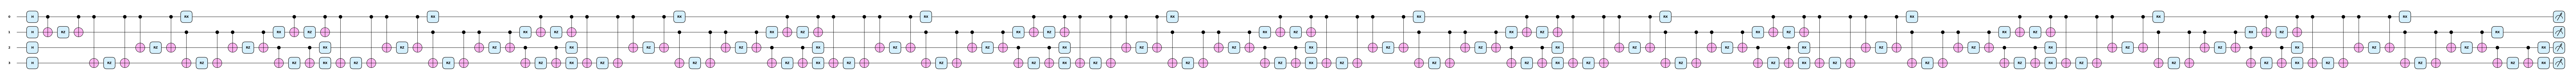

In [8]:
# initialise the parameters array, gamma and beta values for each layer
params = np.array([[np.pi/4, np.pi/8]]*NUM_LAYERS)

# plot the circuit and save in /out/N_node/graph.pdf
fig, ax = qml.draw_mpl(cost_function, style='pennylane')(params)
path = "out/"+str(n_wires)+"_node"
if not os.path.exists(path):
        os.mkdir(path)
plt.savefig(path+"/circuit_"+str(NUM_LAYERS)+"_layers")
plt.show()
plt.close()

## Optimizing the QAOA using a Classical optimizer 

In this section we look to optimize the angles ($ \gamma $ and $ \beta $) being used to run the QAOA using a classical optimizer. This section corresponds step 5 in section 3.3 of the report. In this case we make use of the Gradient Descent optimizer. By default ```STEPS = 200```, however this can be changed in the first code block of the notebook. Essentially the optimizer simply attempts to minimise (remember this is why the Cost Hamiltonian was negated) ```cost_function``` and returns the optimal parameters ($ \gamma $ and $ \beta $) which minimise this function best.

In [9]:
opt = qml.GradientDescentOptimizer()

for _ in range(STEPS):
    params = opt.step(cost_function, params)

## Optimal values for $ \gamma $ and $ \beta $ 

The following are the optimal values for $ \gamma $ and $ \beta $ as determined by the classical optimizer (Gradient descent optimizer).

In [10]:
print(params)
print(cost_function(params))

[[-10.60631018  -1.4675303 ]
 [ -0.77911669  -1.43412004]
 [ -2.82792054   1.67578135]
 [  8.44109583   1.3256517 ]
 [  0.60798677   0.08593312]
 [ -5.8493337    3.52277784]
 [ -9.17118351   3.90523698]
 [ -9.38725752  -0.51800001]
 [-25.6644158    1.02009081]
 [ -7.21974249  -0.26556132]]
4.8230954399338


## Getting a closer look into whats happening 

Its all good and well to plot the final probabilities or amplitudes of each possible solution after the QAOA has been run, but why not make use of pennylane's ```.Snapshot()``` function to get a closer look into what happens to probabilities and amplitudes of each possible solution, after each step of optimising? 

In order to do this, we define a ```_snap``` version of each the following functions:

- ```qaoa_layer(gamma,beta)```
- ```circuit``` 

These perform the same function as the original functions, however they make use of pennylane's ```.Snapshot()``` function to take "snapshots" of the probabilities and amplitudes of each potential solution as the optimisation occurs. 

```circ_state_snap(params)``` runs the QAOA circuit, taking snapshots of the current state, allowing for the amplitude of each possible solution at each step to be determined.

```circ_probs_snap(params)``` runs the QAOA circuit, taking snapshots of the current probabilities of each possible solution, allowing for the probability of each possible solution, at each step to be determined.

This provides a very nice insight into how the QAOA works, as well as why it works (more on this in the report).

In [11]:
def qaoa_layer_snap(gamma,beta):
     U_C(gamma)
     # take snap shot
     qml.Snapshot()
     U_M(beta)
     # take snap shot
     qml.Snapshot()

def circuit_snap(params):
    # create the initial state
    for i in range(n_wires):
        qml.Hadamard(i)

    # run the qaoa_layer function, NUM_LAYERS times, passing 2 params needs
    for i in range(NUM_LAYERS):
         qaoa_layer_snap(params[i,0],params[i,1])

@qml.qnode(dev)                                                        # COMMENT OUT THIS FUNCTION IF FINITE NUMBER OF SHOTS ARE USED  
def circ_state_snap(params):
    circuit_snap(params)
    return qml.state()

@qml.qnode(dev)
def circ_probs_snap(params):
    circuit_snap(params)
    return qml.probs()

# Collect all the snap shots taken of the states and probability
snaps1 = qml.snapshots(circ_state_snap)(params)                         # COMMENT OUT THIS LINE IF FINITE NUMBER OF SHOTS ARE USED
snaps2 = qml.snapshots(circ_probs_snap)(params)

## Determining the change in amplitude and probability of each potential solution

In [12]:
# initialise a array of zeros of length equal to the number of potential solutions (2^n_wires)
intial_array = [0]*(2**n_wires)

# initialise arrays to store the amplitudes and probabilities 
amplitudes = []
probs = []

# add a new row of size 2^n_wires (one position for each potential solution) to each of these arrays for each layer in the circuit
for i in range(2*NUM_LAYERS+1):
    amplitudes.append(intial_array)
    probs.append(intial_array)

# convert these arrays to numpy arrays of an appropriate type
amplitudes = np.array(amplitudes, dtype=float)
probs = np.array(probs, dtype=float)


# populate the probs and amplitudes arrays using snaps2 and snaps1 respectively
for i in range(2*NUM_LAYERS):

    for j in range(2**n_wires):
        # extract the probability of each potential solution from snaps2 and round to 5 decimal places 
        probs[i, j] = np.round(np.real(snaps2[i][j]), decimals=5)

        # determine the amplitude of each potential solution using the solution's coefficient
        amplitudes[i,j] = np.real(snaps1[i][j] * np.conj(snaps1[i][j]))                             # COMMENT OUT THIS LINE IF FINITE NUMBER OF SHOTS ARE USED

# grab the last snap shot taken, stored in the snaps dictionaries with key 'execution_results' 
for j in range(2**n_wires):
    probs[2*NUM_LAYERS][j] = np.round(np.real(snaps2.get('execution_results')[j]), decimals=5)
    amplitudes[2*NUM_LAYERS][j] = np.real(snaps1.get('execution_results')[j] * np.conj(snaps1.get('execution_results')[j]))

## Plotting the change in amplitude and probability of each potential solution

### Utility function for Plotting

The following function simply takes the base 10 representation of a potential solution and returns the binary form with appropriate zero padding.

For example, if a 2-node graph is run, ```bitString(1) = "01"```


In [13]:
# function that takes an index and returns it's corresponding bitstring,
# padded so the bitstring's length is equal to the amount of nodes in the graph.
def bitString(sol):

    bitstring = str(bin(sol)[2:])
    for i in range(len(graph) - len(bitstring)):
        bitstring = "0" + bitstring
   
    return bitstring

### Plotting the change in the probability of each potential solution

In [14]:
# Plot the change in the probability of each potential solution
for i in range(2 ** n_wires):
    plt.plot(probs[:, i], color="b")
    plt.xlabel("Snap shot number (2 snapshots per layer)")
    plt.ylabel("Probability")
    string_rep = bitString(i)
    plt.title("The change in probability of the |"+string_rep+"> solution")

    # save the figure in /out under a folder with name N_node,where N is the number of nodes in the provided graph
    loc = "out/"+str(n_wires)+"_node/probs_graph_"+string_rep+".pdf"
    plt.savefig(loc)
    plt.close()


### Plotting the change in the amplitude of each potential solution

In [15]:
# Plot the change in the amplitude of each potential solution
# COMMENT OUT THIS BLOCK IF A FINITE NUMBER OF SHOTS ARE USED
for i in range(2 ** n_wires):
    plt.plot(amplitudes[:, i], color="r")
    plt.xlabel("Snap shot number (2 snapshots per layer)")
    plt.ylabel("Amplitude")
    string_rep = bitString(i)
    plt.title("The change in amplitude of the |"+string_rep+"> solution")
    
    # save the figure in /out under a folder with name N_node,where N is the number of nodes in the provided graph
    loc = "out/"+str(n_wires)+"_node/amps_graph_"+string_rep+".pdf"
    plt.savefig(loc)
    plt.close()

## Plotting the solution

The following code plots the the solution to the Max Cut problem for the given graph (represeting a given grid) by plotting the graph itself and colouring nodes in the 0-set blue and the 1-set red, to give a visual indication of the determined solution. Note that the edge "wieght" labels here represent the resistances given oringally, this is done to clearly show the solution prioritises low-resistance connections between nodes within a set and cuts high-resistance connections. This solution now serves as a guide as how to lay out a given power grid.

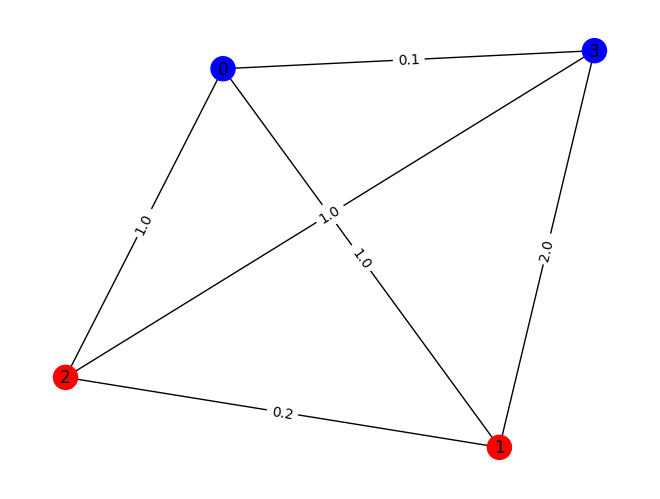

In [16]:
# the last amplitude achieved is assumed to be the best.
best_amplitude = amplitudes[-1]
best_index = np.argmax(best_amplitude)
bitstring = bitString(best_index)

# assign colours to the nodes in the graph depending on if the bit representing
# the group of a node is flipped or not. this way we can visualise the maximum cut.
colours = [''] * len(graph)
nodes = list(graph.nodes)
for i, state in enumerate(bitstring):
    index = nodes.index(i)
    if state == '0':
        colours[index] = 'blue'
    else:
        colours[index] = 'red'

# draw the node graph using the specified colours to represent which group each
# node belongs to
pos = nx.spring_layout(graph, seed=7)
nx.draw(graph, node_color=colours,pos=pos, with_labels=True)
edge_labels = nx.get_edge_attributes(graph, "weight")


for edge,weight in edge_labels.items():
    resistance = 1/weight
    edge_labels[edge] = resistance

nx.draw_networkx_edge_labels(graph,pos, edge_labels)

file = "out/"+str(n_wires)+"_node/"+"graph.pdf"
plt.savefig(file)
plt.show()
plt.close()